<a href="https://colab.research.google.com/github/HanJaeHui-GitHub/ESAA/blob/main/ESAA_OB_Week6_markdown_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 6주차 과제_0407(월)

파이썬 머신러닝 완벽 가이드 개정 2판 8장 p.566-583

## 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge

데이터 속성

- train_id : 데이터 id

- name : 제품명

- item_condition_id : 판매자가 제공하는 제품 상태

- category_name : 카테고리 명

- brand_name : 브랜드 이름

- price : 제품 가격, 예측을 위한 타깃 속성

- shipping : 배송비 무료 여부, 1이면 무료, 0이면 유료

- item_description : 제품에 대한 설명

회귀로 피처를 학습한 뒤 price를 예측하는 문제

텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀 수행한다는 점에서 다름!

### 데이터 전처리

In [1]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/mercari_train.tsv', sep = '\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [2]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


brand_name : Null 값 매우 많음(전체 1482535건 중 849853건)

category_name : 약 6300건의 null 데이터 존재

item_description : 4개의 null 값 → 이후 적절한 문자열로 치환

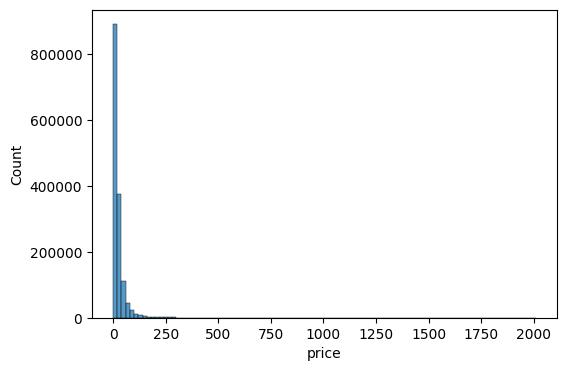

In [3]:
# target 값인 price 칼럼 데이터 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize = (6, 4))
sns.histplot(y_train_df, bins = 100)
plt.show()

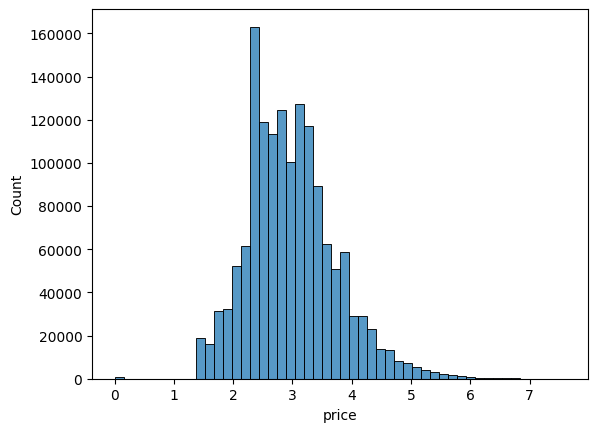

In [4]:
# 적은 가격을 가진 데이터 값에 왜곡돼 분포함으로 로그 값으로 변환한 뒤 분포도 다시 확인
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

In [5]:
# 데이터 세트의 price 칼럼 로그 변환 값으로 변경

mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


In [6]:
# shipping, item_condition_id 피처의 값 살펴보기

print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 shipping
0    819435
1    663100
Name: count, dtype: int64
item_condition_id 값 유형:
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


In [7]:
# item_description 칼럼에 'No description yet'값 갯수 확인
boolen_cond = mercari_df['item_description'] == 'No description yet'
print(boolen_cond.sum())

82489


category_name

'/'로 분리된 카테고리를 하나의 문자열로 나타냄

ex) 'Men/Tops/T-shirts' → 대분류 'Men', 중분류 'Tops', 소분류 'T-shirts'

피처 추출 시 tokenizer를 '/'로 하여 단어를 분리해 벡터화해도 되지만

'/'를 기준으로 단어를 토큰화해 각각 별도의 피처로 저장해 알고리즘 학습에 이용

In [8]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(category_name) :
    try :
        return category_name.split('/')
    except :
        return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값을 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형:\n', mercari_df['cat_dae'].value_counts())
print('중분류 유형:\n', mercari_df['cat_jung'].value_counts())
print('소분류 유형:\n', mercari_df['cat_so'].value_counts())

대분류 유형:
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 유형:
 cat_jung
Athletic Apparel        134383
Makeup                  124624
Tops & Blouses          106960
Shoes                   100452
Jewelry                  61763
                         ...  
Candles                     64
Ceramics and Pottery        57
Dolls and Miniatures        49
Books and Zines             46
Quilts                      31
Name: count, Length: 114, dtype: int64
소분류 유형:
 cat_so
Pants, Tights, Leggings    60177
Other                      50224
Face                       50171
T-Shirts                   46380
Shoes                      32168
               

In [9]:
# brand_name, category_name, item_description 칼럼의 Null 값은 일괄적으로 'Other Null'로 동일하게 변경
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야 함
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


### 피처 인코딩과 피처 벡터화

데이터 세트에 문자열 칼럼이 많음 → 문자열 칼럼 중 레이블 또는 원-핫 인코딩을 수행하거나 피처 벡터화로 변환할 칼럼 선별해보기

선형 회귀와 회귀 트리 모델 적용 예정

선형 회귀 → 원-핫 인코딩 적용을 선호하므로 인코딩할 피처 모두 원-핫 인코딩 적용

피처 벡터화의 경우 짧은 텍스트는 Count 기반 벡터화, 긴 텍스트는 TD-IDF 기반 벡터화 적용

- brand_name

In [10]:
print('brand name의 유형 건수:', mercari_df['brand_name'].nunique())
print(mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수: 4810
brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


대부분 명료한 문자열로 되어 있기 때문에 별도의 피처 벡터화 형태로 만들 필요 없이 인코딩 변환 적용 가능

- name

In [11]:
print('name의 종류 개수:', mercari_df['name'].nunique())
print('name sample 7건:\n', mercari_df['name'][:7])

name의 종류 개수: 1225273
name sample 7건:
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


개별적으로 거의 고유한 상품명을 가짐

유형이 매우 많고 적은 단어 위주의 텍스트 형태 → Count 기반으로 피처 벡터화 변환 적용

- category_name

이전 전처리에서 대, 중, 소 분류 세 개 칼럼으로 분리됨

cat_dae, cat_jung, cat_so 칼럼도 원-핫 인코딩 적용

- shipping

배송비 무료 여부 / 0과 1 두 가지 유형 값

원-핫 인코딩 적용

- item_condition_id

상품 상태 / 1,2,3,4,5 다섯 가지 유형 값

원-핫 인코딩 적용

- item_description

상품에 대한 간단 설명 → 데이터 세트에서 가장 긴 텍스트

In [12]:
# 평균 문자열 크기와 2개 정도 텍스트만 추출하기

pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 오차열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 오차열 크기: 145.71139703278507


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


평균 문자열 : 145자로 비교적 큼 → TF-IDF 변환 적용

**주요 칼럼 인코딩 및 피처 벡터화 변환**

In [13]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


CountVectorizer, TfidfVectorizer가 fit_transform()을 통해 반환하는 데이터는 희소 행렬 형태임

희소 행렬 객체 변수인 X_name과 X_descp를 새로 결합해 새로운 데이터 세트로 구성해야 하고 앞으로 인코딩 될 칼럼도 모두 X_name과 X_descp와 결합돼 ML 모델을 실행하는 기반 데이터 세트로 재구성 되어야 함

따라서 인코딩 대상 칼럼도 희소 행렬 형태로 인코딩 적용한 뒤 함께 결합 진행

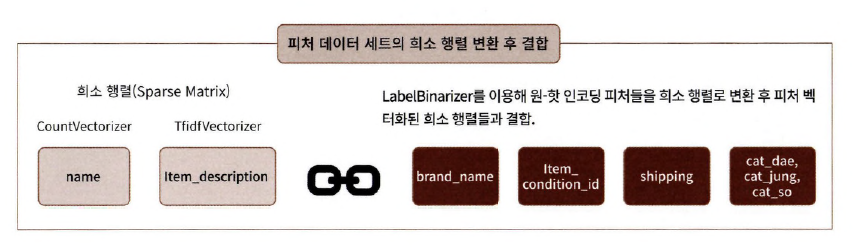

In [14]:
# 인코딩 대상 칼럼을 모두 LavelBinarizer로 원-핫 인코딩 변환

from sklearn.preprocessing import LabelBinarizer

# brand_name 피처를 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

# item_condition_id 피처를 희소 행렬 원-핫 인코딩 변환
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

# shipping 피처를 희소 행렬 원-핫 인코딩 변환
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])


# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [15]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


인코딩 변환된 데이터 세트가 CSR 형태로 변환된 csr_matrix 타입임

> brand_name : 값의 유형이 4810개여서 원-핫 인코딩 변환 시 4810개의 인코딩 칼럼을 가짐

> X_cat_so도 마찬가지로 871개 인코딩 칼럼을 가짐

↪ 피처 벡터화로 텍스트 형태의 문자열이 가지는 백터 형태의 매우 많은 칼럼과 함께 결합되므로 인코딩 칼럼이 많은게 문제 되지 않음

In [16]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


0

hstack()으로 결합한 데이터 세트 : csr_matrix 타입, 총 161568개의 피처를 가짐

### 릿지 회귀 모델 구축 및 평가

여러 알고리즘 모델과 희소 행렬을 변환하고 예측 성능을 비교하면서 테스트를 수행할 것이므로 수행에 필요한 로직 함수화 필요

**모델을 평가(Evaluation) 로직 함수화**

평가 지표 : RMSLE(Root Mean Square Logarithmic Error)

> RMSE와 유사하나 오류 값에 로그를 취해 RMSE를 구하는 방식

> 낮은 가격보다 높은 가격에서 오류가 발생할 경우 오류 값이 더 커지는 것을 억제하기 위해 이 방식 사용

$\epsilon = \sqrt{\frac{1}{n}\displaystyle\sum_{i=1}^n(log(p_i+1)-log(\alpha_i+1))^2}$

In [17]:
def rmsle(y, y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    # 원본의 price 칼럼은 왜곡됨 -> 이를 정규 분포 형태로 유도하기 위해 로그 값을 취해 변환
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    # 원복된 데이터를 기반으로 rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [18]:
import gc
from scipy.sparse import hstack

# model 인자로 사이킷런의 회귀 estimator 객체를 가짐
# matrix_list 인자로 최종 데이터 세트로 결합할 희소 행렬 리스트를 가짐.
def model_train_predict(model, matrix_list):
    # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
    X = hstack(matrix_list)
    X = X.tocsr()

    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'],
                                                        test_size=0.2, random_state=156)

    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    del X, X_train, X_test, y_train
    gc.collect()

    return preds, y_test

In [19]:
# 회귀 예측 수행 전 Metari 상품 가격 예측에 item_description과 같은 텍스트 형태의 속성 영향 확인

linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description 제외 rmsle 값:', evaluate_org_price(y_test, linear_preds))


sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description 포함 rmsle 값:', evaluate_org_price(y_test, linear_preds))

Item Description 제외 rmsle 값: 0.49842594774130644
Item Description 포함 rmsle 값: 0.46810389232555144


item_description 포함했을 때 rmsle 값 감소 → item_description 영향이 중요함을 알 수 있음

## LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

In [20]:
# LightGBM 회귀 수행
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM 값:', evaluate_org_price(y_test, lgbm_preds))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1519.471778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068409
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 65338
[LightGBM] [Info] Start training from score 2.979514


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM 값: 0.4563757852336539


Ridge보다 예측 성능이 더 나아짐

In [21]:
# 0.45*LightGBM + 0.55*Ridge 형태로 예측 결괏값을 서로 앙상블해 최종 예측 결괏값 도출
preds = lgbm_preds*0.45 + linear_preds*0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle값:',evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle값: 0.4465645320297962


간단한 앙상블 방식으로 예측 성능 개선

# 정리

**머신러닝 기반의 텍스트 분석 프로세스**

1. 텍스트 사전 정제 작업 등의 텍스트 정규화 작업 수행

    * 텍스트 정규화 작업

    텍스트 클렌징 및 대소문자 변경, 단어 토큰화, 의미 없는 단어 필터링, 어근 추출 등 피처 벡터화 진행 전 수행하는 다양한 사전 작업 의미

2. 이들 단어들을 피처 벡터화로 변환

    * 피처 벡터화
    
    BOW의 대표 방식인 Count 기반과 TF-IDF 기반 피처 벡터화 방식

    일반적으로 문서의 문장이 긴 경우 TF-IDF가 더 정확한 결과 도출

3. 생성된 피처 벡터 데이터 세트에 머신러닝 모델을 학습, 예측, 평가

    * 만들어진 피처 벡터 데이터 세트가 희소 행렬 형태이기 때문에 머신러닝 모델은 희소 행렬 기반에서 최적화 되어야 함



